In [ ]:
import MetaTrader5 as mt5

In [ ]:
from trader_models import SRUTrader, GPT2Config

import torch
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import pytz

stds = [0.00020527, 0.00015178, 0.00015272, 0.00022341, 0.00463119]

In [ ]:
mt5.initialize(path = "C:/Program Files/Coinexx MT5 Terminal/terminal64.exe",
               login = 806219,
               server = "Coinexx-Demo",
               password = "@Ma4J@p0#@epM#0")

# Finetuning

## collect coinexx data for all currencies

In [199]:
from datasets import Dataset, concatenate_datasets

In [205]:
stds = {
    'AUDUSD':[0.00017544, 0.0001289 , 0.00012869, 0.00020141, 0.00420767],
    'EURCHF':[0.00015943, 0.00012811, 0.00012887, 0.00020714, 0.00346342],
    'EURGBP':[0.00013495, 0.00010049, 0.00010396, 0.00015599, 0.00306316],
    'EURJPY':[0.02540015, 0.01861955, 0.01853017, 0.02725528, 0.60491368],
    'GBPJPY':[0.0333769 , 0.02473986, 0.0244145 , 0.03538734, 0.82613484],
    'GBPUSD':[0.00024653, 0.00018456, 0.00018529, 0.00027917, 0.00578123],
    'USDCAD':[0.00017359, 0.00012897, 0.00013408, 0.00024119, 0.00374798],
    'USDCHF':[0.00017272, 0.00013109, 0.00013035, 0.00022164, 0.00414723],
    'USDJPY':[0.01694065, 0.01276201, 0.01261803, 0.01969121, 0.40558088],
    'EURUSD':[0.00020527, 0.00015178, 0.00015272, 0.00022341, 0.00463119]
}

In [206]:
def make_dataset(currency, periods = 60, stds = None):
    bars = mt5.copy_rates_from(currency, mt5.TIMEFRAME_M1, datetime.now(), 65*1440)
    bars = pd.DataFrame(bars)

    # use coinexx timezone to avoid confusion (where 0:00 is start of trading day)
    bars['time'] = pd.to_datetime(bars['time'], unit='s') - timedelta(hours = 3)
    bars = bars.set_index('time')
    
    fx = bars.asfreq('1min')
    fx['volume'] = fx['tick_volume']
    
    fx['close'] = fx['close'].fillna(method = 'ffill')
    fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

    # fill open high and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })

    # define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

    # let's just arbitrary say there should be less than 500 zero volume -- shouldn't really mattter in the end
    voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 500).index
    fx = fx.loc[voluminous_index]

    futures = {}
    for i in range(1, periods + 1):
        col_name = f'future_close{i}'
        futures[col_name]  = fx['close'].shift(-i) - fx['close']
    futures_df = pd.DataFrame(futures)
    future_cols = futures_df.columns

    fx = pd.concat((fx, futures_df), axis = 1)

    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
    no_futures = fx[fx.groupby('ordinal_day')['day_break'].transform('any')].between_time(f'{20 - periods // 60}:{59 - periods % 60}', '20:59').index
    fx.loc[no_futures, future_cols] = 0

    # de mean using opening price of day
    fx['day_close'] = fx['close'].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)
    fx[['open', 'high', 'low']] = fx[['open', 'high', 'low']].sub(fx['close'], axis = 0)
    fx['close'] = fx['close'] - fx['close'].shift(1)

    #     # de mean volume using rolling average of day
    #     fx["volume"] = fx['volume'] - fx['volume'].groupby(fx['ordinal_day']).rolling(5000, min_periods = 0).mean().reset_index(drop = True, level = 0)

    # get rid of first and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)

    features = ['open', 'high', 'low', 'close', 'day_close']

    fx[features] = fx[features].div(stds[currency], axis = 1)

    ohlcv = fx[features].values.reshape(-1, 1440, 5)
    future = fx[future_cols].values.reshape(-1, 1440, periods)

    # save some memory
    del fx

    ds = Dataset.from_dict({"ohlcv": ohlcv, "future": future})
    return ds

In [207]:
all_datasets = Dataset.from_dict({"ohlcv": [], "future": []}) # just an initialization

for currency in stds.keys():
    dataset = make_dataset(currency, periods = 60, stds = stds)
    print(currency)
    
    all_datasets = concatenate_datasets((all_datasets, dataset))

AUDUSD
EURCHF
EURGBP
EURJPY
GBPJPY
GBPUSD
USDCAD
USDCHF
USDJPY
EURUSD


In [215]:
dataset = all_datasets.train_test_split(.02, shuffle = False)
dataset

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'future'],
        num_rows: 641
    })
    test: Dataset({
        features: ['ohlcv', 'future'],
        num_rows: 14
    })
})

In [228]:
dataset.save_to_disk('data/coinexx-aug-oct.dt')

# Finetune model on coinexx data

### Result: 
for some reason the model isn't able to identify as many trade oppurtunities and has much lower profits -- the main culprit I can see (from just visual chart analysis) is that coinexx provies their in-house bid price as the "price" for ohlc candles which can be quite 'off' when there's low volume (but is extremely similar when there's high volume). This shouldn't pose an issue when trading (since one would only reasonably trade when there's high volume), but does pose a model for getting accurate pricing data that the model can use and reasonably in-distribution.

In [216]:
from transformers import Trainer, TrainingArguments

In [217]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
#         'full trade %': (abs_trade >= .8).mean() * 100,
#         'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
#         'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
#                           / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .8) & (abs_trade >= .5)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .8) & (abs_trade >= .5)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .5) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .5) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit < 0)].mean(),
        
        'micro trade %': ((abs_trade < .15) & (abs_trade >= .1)).mean() * 100,
        'micro trade accuracy': (soft_profit[(abs_trade < .15) & (abs_trade >= .1)] > 0).mean() * 100,
        'micro trade g/l': soft_profit[(abs_trade < .15) & (abs_trade >= .1) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .15) & (abs_trade >= .1) & (soft_profit < 0)].mean(),
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [223]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 10,
    eval_steps = 10,
    report_to = "none",
    learning_rate = 5e-5,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    max_grad_norm = 1,
    fp16 = True,
)

PyTorch: setting up devices


In [224]:
config = GPT2Config(
    n_embd = 448, n_head = 7
)
model = SRUTrader.from_pretrained('srupp.model', config = config).cuda().eval()

loading weights file srupp.model\pytorch_model.bin
All model checkpoint weights were used when initializing SRUTrader.

All the weights of SRUTrader were initialized from the model checkpoint at srupp.model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use SRUTrader for predictions without further training.


In [225]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dataset['train'],
    eval_dataset = dataset['test'],
    compute_metrics = compute_metrics
)

Using cuda_amp half precision backend


In [227]:
trainer.train()

***** Running training *****
  Num examples = 641
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 321
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l,Micro trade %,Micro trade accuracy,Micro trade g/l
10,0.678500,0.677094,0.0668,0.0689,5.6134,0.0053,87.5,3.5253,1.9693,57.2394,0.5636,9.6640,55.6375,0.9371
20,0.679200,0.677613,-0.0586,-0.0497,6.209,0.0287,92.2190,0.8637,3.106,56.2257,0.4972,11.4518,53.7983,0.8418
30,0.682400,0.677176,0.2364,0.2895,5.9066,0.0831,88.8557,4.3689,2.659,64.1296,0.7838,9.8556,54.9344,0.9163
40,0.680000,0.675608,0.4648,0.727,5.3418,0.1772,80.8302,3.7594,2.0070,72.579,1.8290,8.1332,54.2372,1.0298
50,0.685400,0.676420,0.2962,1.1447,3.3462,0.1686,81.4615,3.7596,1.2896,76.6844,2.6995,1.5069,63.0568,1.0549
60,0.675900,0.677618,0.1455,0.7713,3.2484,0.1702,78.679,3.6503,1.3376,74.5859,2.3588,1.8591,58.0621,0.8752
70,0.676600,0.678879,0.1148,0.4161,4.3692,0.4243,79.7545,3.5516,2.6283,64.8717,1.3612,3.9682,48.9031,0.8558
80,0.679400,0.677291,0.1607,0.5139,3.5497,0.296,78.9944,3.4975,1.7980,73.5298,2.1574,3.2226,49.1303,1.0511
90,0.681700,0.677227,0.1221,0.2331,3.8201,0.1045,75.2373,3.8161,1.2612,77.7516,2.6787,3.6462,48.4877,0.9430
100,0.674300,0.679956,0.3865,0.6067,5.1926,0.0063,93.4211,14.0342,0.4253,79.7434,3.8279,5.2562,57.0267,1.1843


***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 14
  Batch size = 2
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=321, training_loss=0.6772050647720741, metrics={'train_runtime': 158.664, 'train_samples_per_second': 4.04, 'train_steps_per_second': 2.023, 'total_flos': 0.0, 'train_loss': 0.6772050647720741, 'epoch': 1.0})

In [16]:
soft_profit, soft_trade = trainer.predict(ds).predictions

***** Running Prediction *****
  Num examples = 60
  Batch size = 1


<ipython-input-10-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
<ipython-input-10-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
<ipython-input-10-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


In [18]:
soft_profit

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.49585641e-04,  7.14117923e-05,  1.62243377e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.64430734e-04,  2.10088954e-04,  1.83061929e-04],
        [ 0.00000000e+00,  0.00000000e+00,  6.24865352e-05, ...,
          2.17204259e-04,  1.66988262e-04,  1.66958242e-04],
        ...,
        [ 4.47448747e-06,  1.28042984e-05,  1.47973205e-05, ...,
         -4.12161262e-06, -8.11238078e-06,  8.11315431e-07],
        [-9.66660991e-06, -8.32455680e-06, -6.23248616e-06, ...,
         -1.16448173e-05, -1.15573885e-05, -3.67991743e-06],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.94259052e-06, -3.50047344e-06, -1.27684780e-05]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.05956497e-04,  4.46323720e-05,  1.47033061e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.02769220e-04,  1.90393112e

In [21]:
np.nansum(soft_profit, axis = (1, 2))

array([-0.10601331,  0.19516471,  0.23336619, -0.05969831, -0.4341677 ,
       -0.02745487,  0.51009107,  0.6031806 ,  0.16753218,  0.4870276 ,
        0.32832676,  0.3179854 ,  0.34116435,  0.12706763,  0.24137959,
        0.29164404, -0.33993146, -0.45186442,  0.57859915,  0.0011117 ,
       -0.01809889, -0.09342682, -0.35466096,  0.33533168, -0.2679992 ,
        0.2728712 , -0.6233173 , -0.30619666,  0.50972503,  0.32917267,
        0.21646272,  0.2082004 ,  0.10806694,  0.33817148,  0.44864586,
        0.10449322,  0.70270455,  0.33602938,  0.12963685, -0.05887564,
        0.4174014 ,  0.33633503,  0.32883826, -0.80043465,  0.65656275,
        0.33215594,  0.8055757 ,  0.4326677 ,  0.06251893,  0.42092678,
        0.25705886,  0.2973602 , -0.21407813,  0.34523734,  0.47126114,
        0.10435741, -0.13981313,  0.836215  , -0.47440407, -0.51945966],
      dtype=float32)

(array([ 1.,  0.,  1.,  1.,  2.,  2.,  2.,  1.,  3.,  5.,  1.,  6.,  6.,
        13.,  3.,  4.,  3.,  2.,  1.,  2.]),
 array([-0.80043465, -0.7186022 , -0.63676965, -0.5549372 , -0.47310472,
        -0.39127225, -0.30943975, -0.22760727, -0.14577478, -0.0639423 ,
         0.01789019,  0.09972267,  0.18155515,  0.26338762,  0.34522012,
         0.42705262,  0.5088851 ,  0.59071755,  0.6725501 ,  0.75438255,
         0.836215  ], dtype=float32),
 <BarContainer object of 20 artists>)

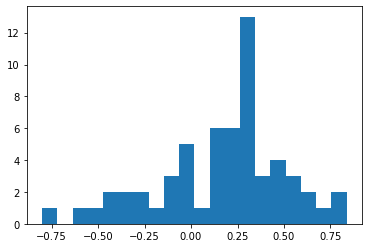

In [305]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)

In [132]:
# full trade percent on 24 hours, ignoring last hour, it makes most trades in london and ny sessions (esp overlap)
((np.abs(soft_trade) > .2).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([24.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [92]:
# full trade accuracy on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > -1, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([0.60239198, 0.45658951, 0.45523148, 0.51649691, 0.48442901,
       0.53009259, 0.49013889, 0.51314815, 0.52763889, 0.49820988,
       0.5032716 , 0.47896605, 0.45555556, 0.4745216 , 0.53973765,
       0.51631173, 0.49580247, 0.54430556, 0.38655864, 0.51762346,
       0.46529321, 0.4346142 , 0.52986111, 0.49816358])

In [93]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > -1, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([ 3.3847431e-05, -3.2217370e-06, -1.3823366e-06,  3.1192237e-06,
       -8.9058602e-07,  2.8054599e-06,  3.2354386e-08,  2.3757050e-06,
        2.5783327e-06,  3.1100519e-06, -4.5968727e-07, -5.2439140e-07,
       -7.0470946e-06, -2.7111716e-06,  3.0191056e-06,  1.8688136e-06,
       -1.8838656e-06,  7.1536351e-06, -8.5836882e-06,  2.9546125e-06,
       -1.1644762e-06, -5.4339516e-06,  2.6458999e-06,  2.9302541e-06],
      dtype=float32)

In [96]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .2).mean(axis = (0, 1))

array([0.01354167, 0.0123071 , 0.01134259, 0.01165123, 0.01145833,
       0.01195988, 0.01118827, 0.01134259, 0.01126543, 0.01114969,
       0.01130401, 0.01084105, 0.01145833, 0.01076389, 0.01207562,
       0.01084105, 0.01084105, 0.01130401, 0.01153549, 0.01049383,
       0.01253858, 0.01091821, 0.01253858, 0.01114969, 0.01149691,
       0.01226852, 0.01153549, 0.01253858, 0.01138117, 0.01257716,
       0.0117284 , 0.01118827, 0.01388889, 0.01365741, 0.01153549,
       0.0128858 , 0.01381173, 0.01458333, 0.01222994, 0.01481481,
       0.01315586, 0.01346451, 0.01392747, 0.01415895, 0.01377315,
       0.01666667, 0.0185571 , 0.01566358, 0.0148534 , 0.01431327,
       0.01257716, 0.01585648, 0.01400463, 0.01728395, 0.01940586,
       0.0148534 , 0.01423611, 0.01466049, 0.01566358, 0.0154321 ])

In [97]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 1))

array([0.4017094 , 0.48589342, 0.55442177, 0.56622517, 0.56902357,
       0.59677419, 0.62413793, 0.64965986, 0.65753425, 0.6816609 ,
       0.64163823, 0.70106762, 0.67340067, 0.67741935, 0.66453674,
       0.70818505, 0.74021352, 0.75085324, 0.72909699, 0.74264706,
       0.75384615, 0.74204947, 0.77538462, 0.78546713, 0.78187919,
       0.78930818, 0.80602007, 0.78769231, 0.82711864, 0.79754601,
       0.8125    , 0.81034483, 0.78888889, 0.79943503, 0.78595318,
       0.76946108, 0.77094972, 0.75396825, 0.76971609, 0.72916667,
       0.76246334, 0.747851  , 0.74238227, 0.74386921, 0.73109244,
       0.73842593, 0.73180873, 0.74876847, 0.74285714, 0.71698113,
       0.74539877, 0.7323601 , 0.72727273, 0.72321429, 0.71769384,
       0.70909091, 0.69918699, 0.69473684, 0.68472906, 0.695     ])

In [98]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .2) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([3.87642431e-05, 4.82867217e-05, 5.30346224e-05, 5.71032870e-05,
       6.46000990e-05, 6.61578815e-05, 7.37340742e-05, 7.77207388e-05,
       8.10080455e-05, 8.79798972e-05, 9.58662858e-05, 9.60033867e-05,
       1.02072954e-04, 1.16274234e-04, 1.19394033e-04, 1.19139942e-04,
       1.17188356e-04, 1.15627976e-04, 1.26749801e-04, 1.31460358e-04,
       1.23007601e-04, 1.28528467e-04, 1.26307772e-04, 1.29251872e-04,
       1.31724111e-04, 1.25308972e-04, 1.34633490e-04, 1.35371287e-04,
       1.38837029e-04, 1.36575953e-04, 1.40024538e-04, 1.46841237e-04,
       1.43064666e-04, 1.43730504e-04, 1.55068774e-04, 1.59900490e-04,
       1.49507308e-04, 1.60183365e-04, 1.67679274e-04, 1.74265922e-04,
       1.73987894e-04, 1.79771640e-04, 1.84036020e-04, 1.88592050e-04,
       2.09701611e-04, 1.84028962e-04, 1.83535376e-04, 1.98230890e-04,
       2.14863569e-04, 2.15544947e-04, 2.32790320e-04, 2.22888921e-04,
       2.47044110e-04, 2.32334700e-04, 2.09812380e-04, 2.64622940e-04,
      

In [99]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .2) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-2.6926531e-05, -2.4322924e-05, -3.6522557e-05, -3.8901489e-05,
       -4.3621127e-05, -4.8837319e-05, -5.5283203e-05, -4.6932801e-05,
       -6.6117143e-05, -5.5267577e-05, -6.4423220e-05, -5.6105258e-05,
       -7.0949936e-05, -6.3110703e-05, -6.8579480e-05, -7.1946619e-05,
       -7.2963376e-05, -7.2417031e-05, -6.0837709e-05, -5.6984212e-05,
       -6.3431260e-05, -5.9233374e-05, -7.0768765e-05, -7.1119808e-05,
       -6.7338420e-05, -6.3440297e-05, -6.3099731e-05, -7.9270001e-05,
       -7.5724965e-05, -6.7836656e-05, -6.6763074e-05, -6.5900815e-05,
       -6.6884932e-05, -5.7525474e-05, -6.2009902e-05, -6.6585089e-05,
       -7.0515591e-05, -6.9099318e-05, -6.9504269e-05, -6.4450585e-05,
       -6.5847002e-05, -6.2522020e-05, -6.4975997e-05, -6.6394976e-05,
       -7.0697919e-05, -7.3487092e-05, -7.5647200e-05, -7.4289972e-05,
       -7.9624377e-05, -7.5277763e-05, -7.6286298e-05, -7.8171390e-05,
       -6.9987487e-05, -7.2869174e-05, -7.5058218e-05, -7.2723757e-05,
      

# Try model on Twelvedata numbers (third party data provider)

### Result:
The numbers are much better with the model actually producing 30s and 40s for probabilities.

### Conclusion:
Third-party data should be used, but likely still requires some finetuning

In [265]:
config = GPT2Config(
    n_embd = 448, n_head = 7
)
model = SRUTrader.from_pretrained('srupp.model', config = config).cuda().eval()

loading weights file srupp.model\pytorch_model.bin
All model checkpoint weights were used when initializing SRUTrader.

All the weights of SRUTrader were initialized from the model checkpoint at srupp.model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use SRUTrader for predictions without further training.


In [374]:
import requests
import io

response = requests.get("https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=1min&outputsize=full&apikey=FF4BNWSJ67ZFOVT4")


In [375]:
df = pd.DataFrame.from_dict(response.json()['Time Series FX (1min)']).T
df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close'})

In [371]:
response = requests.get(f"https://api.twelvedata.com/time_series?apikey=b1380736fa4d496881c9a1fc87d3dcb3&interval=1min&symbol=EUR/USD&outputsize=4320&start_date=2022-10-01 00:20:00&end_date={datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
df = pd.DataFrame.from_dict(response.json()['values'])

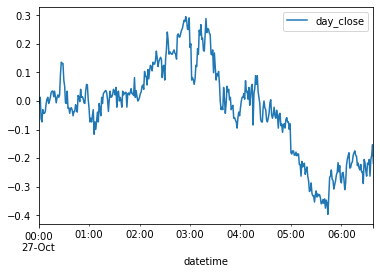

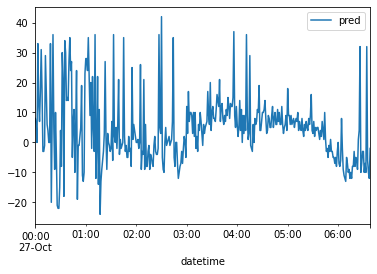

In [380]:
bars = df.iloc[::-1].reset_index(names = 'datetime')

# use coinexx timezone to avoid confusion (where 0:00 is start of trading day)
bars['datetime'] = pd.to_datetime(bars['datetime']) + timedelta(hours = 3)
bars = bars.set_index('datetime')
bars = bars.astype(float)

# preprocessing (same code as original)
bars['day_close'] = bars['close'].sub(bars.groupby(bars.index.day)['close'].transform('first'), axis = 0)
bars[['open', 'high', 'low']] = bars[['open', 'high', 'low']].sub(bars['close'], axis = 0)
bars['close'] = bars['close'] - bars['close'].shift(1)

# filter to only today
bars = bars[bars.index.day == bars.index.day[-1]]

bars = bars[['open', 'high', 'low', 'close', 'day_close']]
bars = bars.div(stds['EURUSD'], axis = 1)

with torch.no_grad():
    model = model.eval()
    bars['pred'] = (model(torch.Tensor(bars.values).unsqueeze(0).cuda())[0].mean(dim = 1) * 100).round().cpu().numpy()
    bars[['day_close']].plot()
    bars[['pred']].plot()